# Data preparation

In [1]:
# Directory navigation
import os

# Data handling
import datetime
from enum import Enum
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# EO-specific imports
from sentinelhub import BBoxSplitter, BBox, CRS
from eolearn.core import EOPatch, EOTask, FeatureType, OverwritePermission, LoadTask, SaveTask, LinearWorkflow, EOExecutor
from eolearn.mask import get_s2_pixel_cloud_detector, AddCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, ErosionTask
from eolearn.features import SimpleFilterTask

In [2]:
# Path configuration
DATA_FOLDER = 'data'
PATCH_FOLDER = os.path.join(DATA_FOLDER, 'lcc_eopatches')
LOGS_FOLDER = os.path.join(DATA_FOLDER, 'logs')

## 1. Defining the Area-of-Interest (AOI)

We will focus on the Republic of Slovenia for this example, mostly due to the accessibility of its reference data. The boundary of the country was obtained from [Natural Earth](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/), a public domain map data set.

The boundary comes stored in the form of polygonal coordinates within a `JSON` file. We can use `geopandas` to work with this type of data:

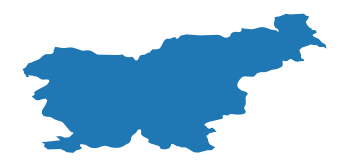

In [3]:
# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, 'svn.geojson'))

# Plot country
country.plot()

plt.axis('off');

While the shape of Slovenia is recognisable, something seems a bit off. The fault can be found in the present coordinate reference system (CRS):

In [4]:
country.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can suspect that the scope of the CRS is a bit large for our use case. To confirm our suspicions, we can consult the [EPSG Geodetic Parameter Dataset](http://www.epsg-registry.org/) (still named after the European Petroleum Survey Group, which constructed it) which contains worldwide CRS descriptions and can help us to better understand the CRS code above.

In view of https://epsg.io/4326, the code resolves to:
> ***Scope:*** *Horizontal component of 3D system. Used by the GPS satellite navigation system and for NATO military geodetic surveying.*

> ***Area of use:*** *World.*

Constraining the CRS to something more local serves more than just to make our shape look better. It is also recommended to avoid potential issues with data downloads if Sentinel Hub services were to be used.

### 1.1 Setting the appropriate CRS

You may remember from the introduction that the world map in the [Universal Transverse Mercator system](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) is split into 60 vertical zones. Sentinel-2's tiling system then segments them horizontally, but for the CRS, the only further split is in terms of hemisphere.

Thus, Slovenia falls into zone UTM 33N (33rd zone, northern hemisphere). We could look up the EPSG code that represents it, but the `CRS` object already takes care of that for us:

In [5]:
CRS.UTM_33N.epsg

32633

Now we can re-coordinate the country using the new CRS...

In [6]:
country_crs = CRS.UTM_33N
country = country.to_crs(epsg=country_crs.epsg)

country.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 12°E to 18°E - by country
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

...and confirm that it looks proper:

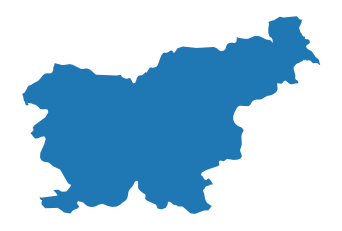

In [7]:
# Plot country
country.plot()

plt.axis('off');

### 1.2 Splitting the AOI

Due to limited computational resources, our AOI is far too large for us to process at once, especially if we are to consider an entire year's worth of data, so it will have to be split into smaller and more manageable patches.

Naturally, you can define an AOI of arbitrary size, but in practice, they are usually of country-level scale. An example from one of Sinergise's [blog posts](https://medium.com/sentinel-hub/land-cover-monitoring-system-84406e3019ae):

<img src="images/lcms_turkey.png">

What we need to do next, is to define the location of each patch within their shared CRS. To this end, we can use `BBoxSplitter` from `sentinelhub-py` to split the country into non-overlapping rectangular bounding boxes. Each will later on be used do define an `EOPatch`.

**NOTE:** For legacy reasons, this part will be performed on a map with added buffer. The same process as before applies:

In [8]:
country = gpd.read_file(os.path.join(DATA_FOLDER, 'svn_buffered.geojson'))
country = country.to_crs(epsg=country_crs.epsg)

Let's see how big of an area this is, so that we can determine how best to split it:

In [9]:
# Get polygon
country_shape = country.geometry.tolist()[-1]

# Use bounds to determine width and height
print('Width:  %.0f m' % (country_shape.bounds[2] - country_shape.bounds[0]))
print('Height: %.0f m' % (country_shape.bounds[3] - country_shape.bounds[1]))

Width:  249870 m
Height: 171656 m


Splitting the area into a 25x17 grid seems intuitive, as we would get patches of about 1000x1000 pixels at 10 m resolution, but generally, the splitting choice depends on the available resources of your machine.

Before going ahead, let's first check the raw data size per patch that our choice would lead to. Assuming Sentinel-2's revisit time of about 5 days for our AOI, we should get about 70 observations for each patch throughout the year. Coupled with 13 bands and 32-bit (single-precision) floating-point format...

In [10]:
# t*h*w*d * precision * byte conversion * prefix (giga) multiplier
print('Patch size: %.1f GB' % (70*1000*1000*13 * 32 / 8 * 1e-9))

Patch size: 3.6 GB


...we get something that is, actually, not that unreasonable to work with, but your machines will probably appreciate a lighter load.

Therefore, we will split the area into patches that are 9 times smaller, i.e. 75x51 patches of size about 333x333 pixels at 10 m resolution:

In [11]:
# t*h*w*d * precision * byte conversion * prefix (mega) multiplier
print('Patch size: %.1f MB' % (70*333*333*13 * 32 / 8 * 1e-6))

Patch size: 403.6 MB


Before you downloaded the data, it has been compressed to approx. 130 MB per patch, but you can confirm the size that they would extract to. In any case, this ought to make the numbers more manageable.

Now we can use the splitter to obtain a list of bounding boxes:

In [12]:
bbox_splitter = BBoxSplitter([country_shape], country_crs, (75, 51))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

len(bbox_list)

2352

In [ ]:
# Note: info_list includes the patches' coordinates within the grid.

Since this is just an example, processing all 2352 patches would be unnecessary. Instead, we will be focusing on a particular 3x3 neighbourhood.

In [13]:
# Determine the central patch
central_idx = 1549

central_index_x = info_list[central_idx]['index_x']
central_index_y = info_list[central_idx]['index_y']

# Find its neighbours
patch_indices = []

for idx, neighbour in enumerate(info_list):
    if (abs(neighbour['index_x'] - central_index_x) <= 1 and
        abs(neighbour['index_y'] - central_index_y) <= 1):
        patch_indices.append(idx)

# Change the patches' order (for proper plotting)
patch_indices = np.transpose(np.fliplr(np.array(patch_indices).reshape(3, 3))).flatten()

In [ ]:
# Note: You are free to set another neighbourhood of patches,
#       but the results may be unpredictably underwhelming,
#       i.e. you may end up in an area with nothing but forests, or similar.

Let's visualize the selection:

In [14]:
# Form a 3x3 grid of bounding boxes
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patch_indices]]

indices_x = [info['index_x'] for info in info_list[patch_indices]]
indices_y = [info['index_y'] for info in info_list[patch_indices]]

gdf = gpd.GeoDataFrame({'index_x': indices_x, 'index_y': indices_y},
                       crs={'init': CRS.ogc_string(country_crs)},
                       geometry=geometry)

C:\Users\jerne\Anaconda3\envs\eow\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


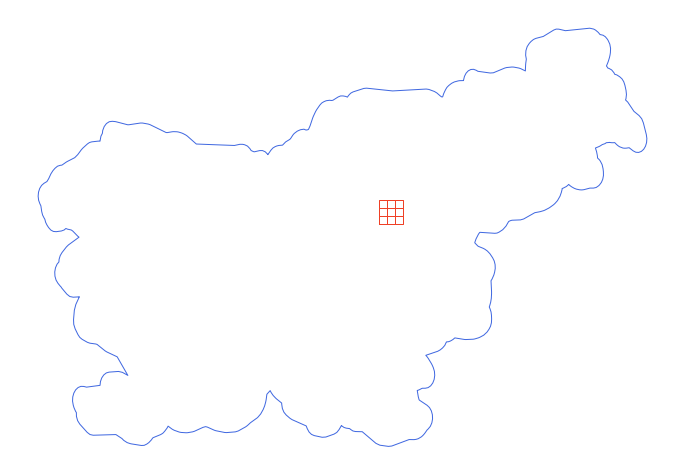

In [15]:
_, ax = plt.subplots(1,1,figsize=(12,12))

# Plot country's boundary
country.plot(ax=ax, facecolor='white', edgecolor='royalblue')

# Plot patches' bounding boxes
gdf.plot(ax=ax, facecolor='white', edgecolor='xkcd:tomato')

plt.axis('off');

## 2. Downloading Sentinel-2 data

Normally, an `EOPatch` would be created through the use of Sentinel Hub services: by sending out requests with specified bounding boxes and a time interval, the patches would be filled with Sentinel-2 data.

However, due to the reasons that were mentioned in the introduction, the patches - containing Sentinel-2 data throughout the year of 2017 -  have been prepared beforehand. See [the docs](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html) if you are nonetheless interested in how this was done.

So, we can simply load the patches and sit back over a job well done.

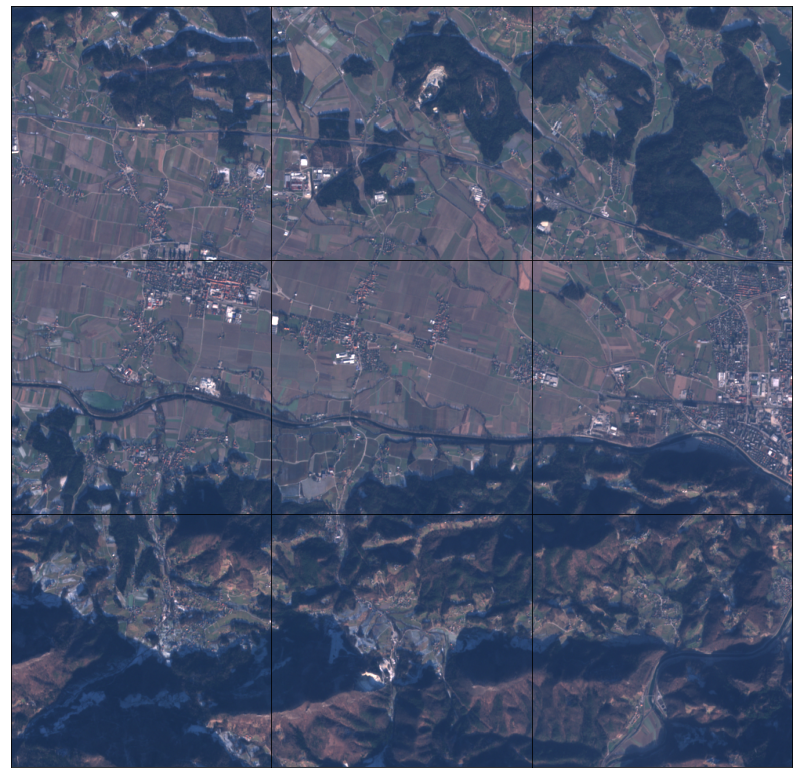

In [16]:
# Plot the RGB image
fig, axes = plt.subplots(3,3,figsize=(14,14))

for ax, patch_name in zip(axes.flatten(), os.listdir(PATCH_FOLDER)):
    # Load patch
    eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, patch_name), lazy_loading=True)
    
    # Plot brightened RGB bands (values clipped so that matplotlib is satisfied)
    ax.imshow(np.clip(eopatch.data['BANDS'][0][..., [3, 2, 1]] * 3.5, 0., 1.))
    
    # Dereference and hope that the garbage collector gets it
    del eopatch
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')

fig.subplots_adjust(wspace=0, hspace=0)

## 3. Preprocessing pt. I

We will add some data that can be useful either in preparation of our data set or as its features. To each patch, we will add:
- cloud masks and valid pixel maps, which will be used to filter ineligible images or pixels,
- combinations of bands as additional features that will be used alongside a selection of bands by our classifier,
- a reference map, from which the labels will be drawn.

This defines a sequence of tasks, which is best formulated as an `EOWorkflow`.

### 3.1 Valid pixels

We will run a cloud detector over all time frames, which will generate cloud probability maps and masks...

In [17]:
# The parameters affect smoothing and dilation of the cloud mask
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=True)

add_cloud_mask = AddCloudMaskTask(
    cloud_classifier,    # classifier to use
    'BANDS',             # data feature to be used as input for the classifier
    cm_size_y='80m',     # resolution on which to run the classifier
    cm_size_x='80m',
    cmask_feature='CLM', # cloud mask feature name
    cprobs_feature='CLP' # cloud probability map feature name
)

In [ ]:
# Note: The "all_bands" parameter implies that the cloud detector can work without having all 13 bands supplied.
#       More details:
#       https://github.com/sentinel-hub/sentinel2-cloud-detector/blob/master/s2cloudless/S2PixelCloudDetector.py

In [ ]:
# Note: Since clouds tend to be bigger, focusing on 10x10 m pixels would lead to plenty of noise in the output,
#       thus, for cloud detection, high-resolution images typically don't provide significant benefit.
#       s2cloudless was not trained on high-resolution samples, anyway.

...and use a predicate to consider both the cloud mask and the "within sensor range"-mask (some images may look half-empty):

In [18]:
class ValidDataPredicate:
    """
    Computes the valid data map as:
        not CLOUD_MASK and IS_DATA
    """
    
    def __init__(self, cmask_feature, is_data_feature):
        self.cmask_feature = cmask_feature
        self.is_data_feature = is_data_feature
        
    def __call__(self, eopatch):
        cloud_mask = eopatch.mask[self.cmask_feature].astype(np.bool)
        is_data = eopatch.mask[self.is_data_feature].astype(np.bool)
        
        return (~cloud_mask) & is_data


add_valid_mask = AddValidDataMaskTask(
    ValidDataPredicate('CLM', 'IS_DATA'), # our predicate
    'IS_VALID'                            # output feature name
)

### 3.2 Adding features

Manually adding features to the samples has been falling out of favour, as capable modern algorithms can internally do the same - and are increasingly better at it, too. In fact, attempts to use human domain knowledge can insert bias in them and even asymptotically *limit* their performance, so the best you can do is, probably, to just feed them more data (summarised in [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) or, if you prefer a video, [Compute Reigns Supreme](https://www.youtube.com/watch?v=wEgq6sT1uq8)).

That being said, our simple boosted trees might still have some use for our help.

From the multispectral data at hand, we will compute the following additional features:
- [Normalised difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)
- [Normalised difference water index (NDWI)](https://en.wikipedia.org/wiki/Normalized_difference_water_index)
- Euclidean norm (implying magnitude)

In [ ]:
# Note: Although NDVI and NDWI have some theoretical precedent,
#       you may use any combination of bands if it seems promising or interesting.
#       The classifier should be able to work with anything you give it (just don't produce NaNs).
#       For this purpose, you may find EOBrowser's custom script capabilities useful:
#       https://www.sentinel-hub.com/explore/eobrowser

In [19]:
class NormalizedDifferenceIndexTask(EOTask):   
    """
    Computes the Normalised Difference Index (NDI) between bands A and B as:
        NDI = (A-B)/(A+B).
    """
    
    def __init__(self, ndi_feature, a_feature_idx, b_feature_idx):
        self.ndi_feature = ndi_feature
        self.a_feature, self.a_idx = a_feature_idx
        self.b_feature, self.b_idx = b_feature_idx
        
    def execute(self, eopatch):
        a = eopatch.data[self.a_feature][..., self.a_idx]
        b = eopatch.data[self.b_feature][..., self.b_idx]
        
        ndi = (a - b) / (a + b)
        
        eopatch.add_feature(FeatureType.DATA, self.ndi_feature, ndi[..., np.newaxis])
        
        return eopatch


add_ndvi = NormalizedDifferenceIndexTask('NDVI', ('BANDS', 7), ('BANDS', 3))
add_ndwi = NormalizedDifferenceIndexTask('NDWI', ('BANDS', 2), ('BANDS', 7))

In [20]:
class EuclideanNormTask(EOTask):   
    """
    Computes the Euclidean norm:
        norm = sqrt(sum_i Bi**2),
    where Bi are the individual channels of the given array.
    """
    
    def __init__(self, norm_feature, data_feature):
        self.norm_feature = norm_feature
        self.data_feature = data_feature
    
    def execute(self, eopatch):
        data = eopatch.data[self.data_feature]
        norm = np.sqrt(np.sum(np.power(data, 2), axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.norm_feature, norm[..., np.newaxis])
        
        return eopatch
    
add_norm = EuclideanNormTask('NORM', 'BANDS')

### 3.3 Land use/land cover reference map

Generally, LULC data sets are hard to come by, especially those of high-quality (i.e. detailed and accurate). As it happens, Slovenia has got things sorted out quite well.

The most recent version of Slovenia's country-wide reference data set is accesible from the [official source](http://rkg.gov.si/vstop/) (`Grafični podatki RABA za celo Slovenijo (shape.rar ~ 500 MB) KoordSistem: D96/TM`), but note that it adheres to the national `D96/TM` coordinate system and would need to be synchronised with the rest of our data before we could use it.

We will be using a subset of the data for 2017, already converted to the `UTM_33N` CRS. In the form of a shapefile, it contains polygons and their corresponding labels, which are of the following classes:
- `lulcid`: 0, `name`: no data
- `lulcid`: 1, `name`: cultivated land
- `lulcid`: 2, `name`: forest
- `lulcid`: 3, `name`: grassland
- `lulcid`: 4, `name`: shrubland
- `lulcid`: 5, `name`: water
- `lulcid`: 6, `name`: wetlands
- `lulcid`: 7, `name`: tundra
- `lulcid`: 8, `name`: artificial surface
- `lulcid`: 9, `name`: bareland
- `lulcid`: 10, `name`: snow and ice

What we need to do is create a raster (pixel form) map from the polygons (vector form), where each pixel in the resulting reference map is assigned a class:

In [21]:
# LULC data
land_cover_data = gpd.read_file(
    os.path.join(DATA_FOLDER,  'land_cover_subset_small', 'land_cover_subset_small.shp')
)

add_reference_map = VectorToRaster(
    land_cover_data,                            # data
    (FeatureType.MASK_TIMELESS, 'LULC'),        # reference map feature name
    values_column='lulcid',                     # relevant key in the data
    raster_shape=(FeatureType.MASK, 'IS_DATA'), # could be a tuple or any feature, from which the dimensions can be inferred
    raster_dtype=np.uint8                       # data type
)

### 3.4 The workflow

We still need to define the I/O tasks:

In [22]:
load = LoadTask(PATCH_FOLDER)
save = SaveTask(PATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [ ]:
# Note: overwriting the patches, just this first time, will get rid of compression,
#       making the patches load faster for subsequent processes.

Although only `add_valid_mask` has a strict dependency (on `add_cloud_mask`), it is still appropriate to define a `LinearWorkflow`:

C:\Users\jerne\Anaconda3\envs\eow\lib\site-packages\holoviews\operation\datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


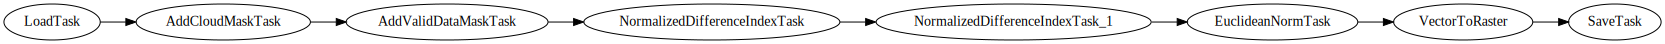

In [23]:
workflow = LinearWorkflow(
    load,
    add_cloud_mask,
    add_valid_mask,
    add_ndvi,
    add_ndwi,
    add_norm,
    add_reference_map,
    save
)

workflow.dependency_graph()

We can now execute the workflow:

In [25]:
%%time

# The only patch-specific parameters are their individual names
execution_args = []

for patch_name in os.listdir(PATCH_FOLDER):
    execution_args.append({
        load: {'eopatch_folder': patch_name},
        save: {'eopatch_folder': patch_name}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)

# Don't set this high if you don't have enough RAM...
executor.run(workers=1, multiprocess=False)

executor.make_report()

We now have patches that look like this:

In [26]:
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_2'))
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(69, 337, 333, 13), dtype=float32)
    CLP: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(69, 337, 333, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(69, 337, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(337, 333, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ['2017-01-01', '2017-12-31']
  }
  bbox: BBox(((516820.8120355235, 5122327.2

### 3.5 Results

#### 3.5.1 Cloud interference

Let's take a look at how the presence of clouds can significantly affect our data.

If we choose a patch with lots of vegetation and plot the mean NDVI throughout the year, we would expect it to oscillate between summer and winter:

C:\Users\jerne\Anaconda3\envs\eow\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


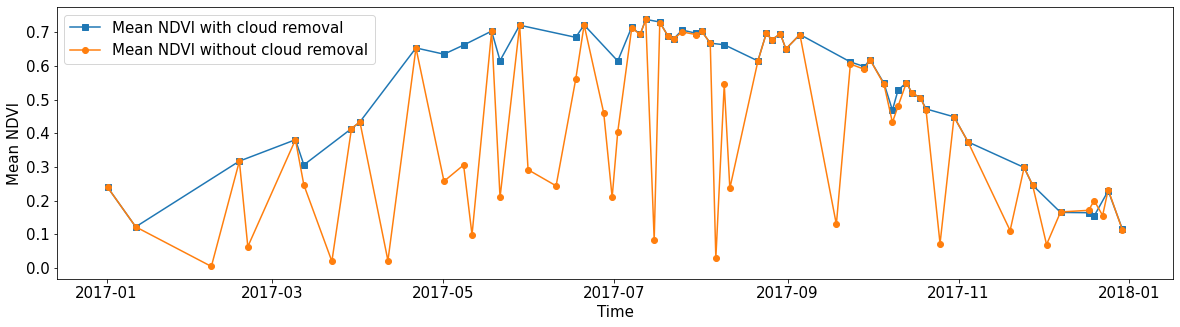

In [27]:
# Load some patch
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_7'), lazy_loading=True)

ndvi = eopatch.data['NDVI']
is_data = eopatch.mask['IS_DATA']
cloud_mask = eopatch.mask['CLM']
time = np.array(eopatch.timestamp)
t, w, h, _ = ndvi.shape

# Filter
ndvi = np.where(is_data, ndvi, np.nan)
ndvi_clean = np.where(~cloud_mask, ndvi, np.nan)

# Spatial mean
mean_ndvi = np.nanmean(ndvi.reshape(t, w*h), axis=1)
mean_ndvi_clean = np.nanmean(ndvi_clean.reshape(t, w*h), axis=1)

# Remove remaining NaNs (left if all observations were cloudy and no mean could be calculated for that time frame)
time_clean = time[~np.isnan(mean_ndvi_clean)]
mean_ndvi_clean = mean_ndvi_clean[~np.isnan(mean_ndvi_clean)]

# Plot
plt.figure(figsize=(20,5))

plt.plot(time_clean, mean_ndvi_clean, 's-', label = 'Mean NDVI with cloud removal')
plt.plot(time, mean_ndvi, 'o-', label='Mean NDVI without cloud removal')

plt.xlabel('Time', fontsize=15)
plt.ylabel('Mean NDVI', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', prop={'size': 15});

We can see that clouds insert a lot of noise, making it harder to observe a trend and learn from it. This implies that we will have to remove them before training our classifier.

However, cloud removal brings some problems itself.

Let's plot the average cloud probability for each pixel throughout the year. We would expect the resulting image to be more or less random, with no discernable structures (although in some cases, e.g. with high mountains, clouds could realistically accumulate in certain parts of the image):

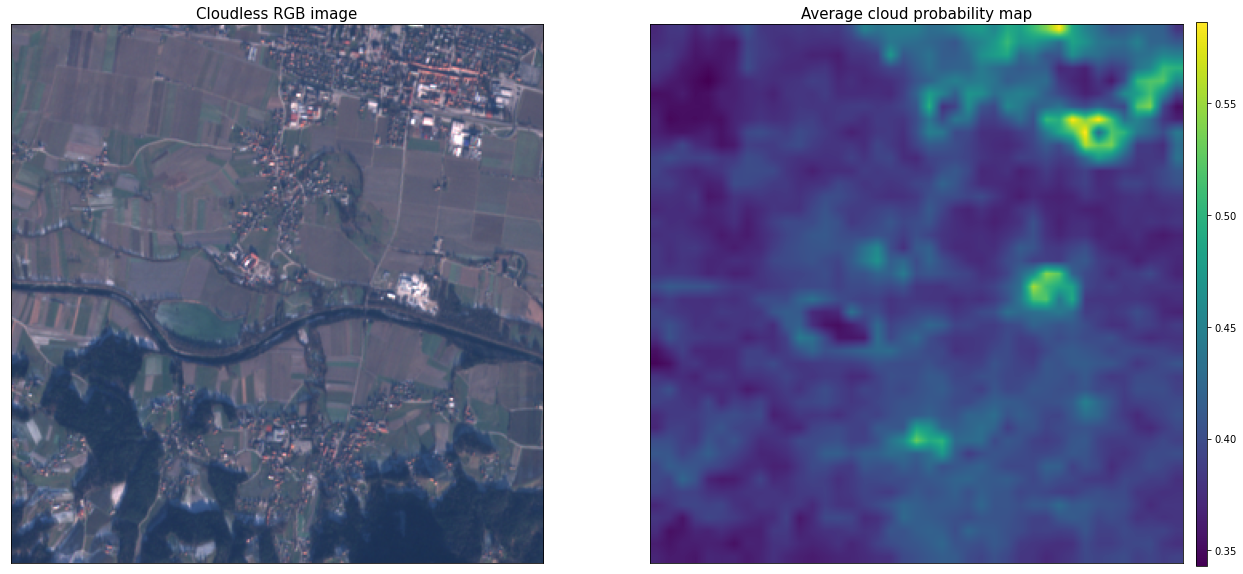

In [29]:
# Load some patch
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_3'), lazy_loading=True)

clp = eopatch.data['CLP'][...,0]
is_data = eopatch.mask['IS_DATA'][...,0]

# Temporal mean
clp = np.where(is_data, clp, np.nan)
clp = np.nanmean(clp, axis=0)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,10))

_ = ax1.imshow(np.clip(eopatch.data['BANDS'][0][..., [3,2,1]] * 3.5, 0., 1.))
clp_map = ax2.imshow(clp, cmap=plt.cm.viridis)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('Cloudless RGB image', fontsize=15)
ax2.set_title('Average cloud probability map', fontsize=15)

cb = fig.colorbar(clp_map, ax=[ax1, ax2], orientation='vertical', pad=0.01, aspect=50)

We see that, due to inherent bias in the cloud detector, things like the river, the coast of the lake, roads, and bright roofs are assigned relatively high cloud probability. If we consider that s2cloudless marks everything above the threshold of `0.4` as clouds, we can surmise that many such samples will be needlessly thrown away with by our cloud removal.

This can also be problematic, especially if the samples that we are throwing away turn out to be particularly important. We can hope that not all time frames are affected and, thus, that the gaps that we create can be properly filled with linear interpolation, but the viability of results is not guaranteed.

As mentioned in the introduction, this problem could be potentially avoided by choosing a different model, one that does not need us to perform this kind of preprocessing.

#### 3.5.2 Feature subset selection

Some features are more informative than others and, in this case, they are all highly correlated. Therefore, it is not necessary to have our classifier consider all of them.

Let's visualise an example and see how they compare. First, on the same scale...

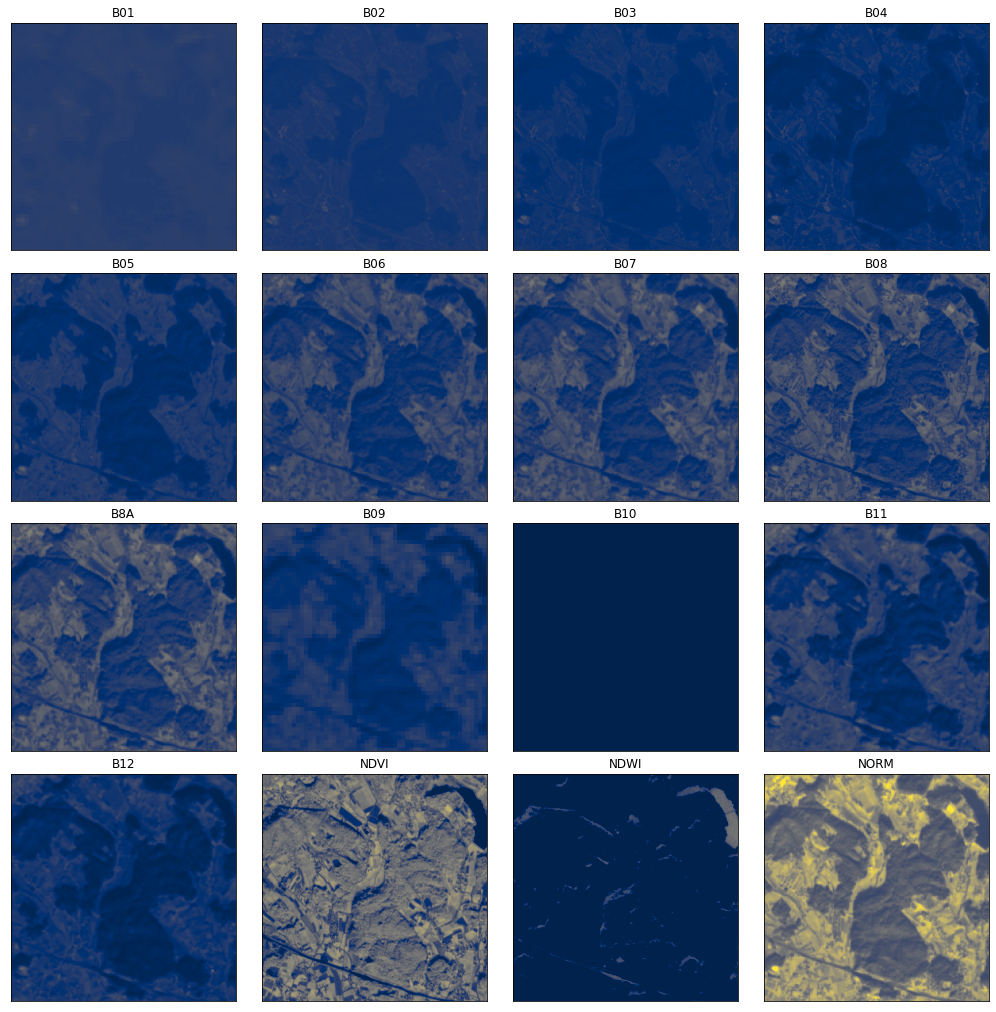

In [30]:
# Load some patch
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_2'), lazy_loading=True)

titles = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12', 'NDVI', 'NDWI', 'NORM']

# Plot
fig, axes = plt.subplots(4,4,figsize=(18,18))

def pretty_plot(ax, data, vmin, vmax, title):
    """
    If there are issues with colour-blindness, change the colour map to something else:
    https://matplotlib.org/tutorials/colors/colormaps.html
    """ 
    
    ax.imshow(data, vmin=vmin, vmax=vmax, cmap=plt.cm.cividis)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot bands
for i in range(13):
    data = eopatch.data['BANDS'][0,...,i]
    pretty_plot(axes.flat[i], data, 0., 1., titles[i])

# Plot NDVI
i = 13
data = eopatch.data['NDVI'][0,...,0]
pretty_plot(axes.flat[i], data, 0., 1., titles[i])

# Plot NDWI
i = 14
data = eopatch.data['NDWI'][0,...,0]
pretty_plot(axes.flat[i], data, 0., 1., titles[i])

# Plot NORM
i = 15
data = eopatch.data['NORM'][0,...,0]
pretty_plot(axes.flat[i], data, 0., 1., titles[i])

fig.subplots_adjust(wspace=0., hspace=0.1);

...and within their individual ranges:

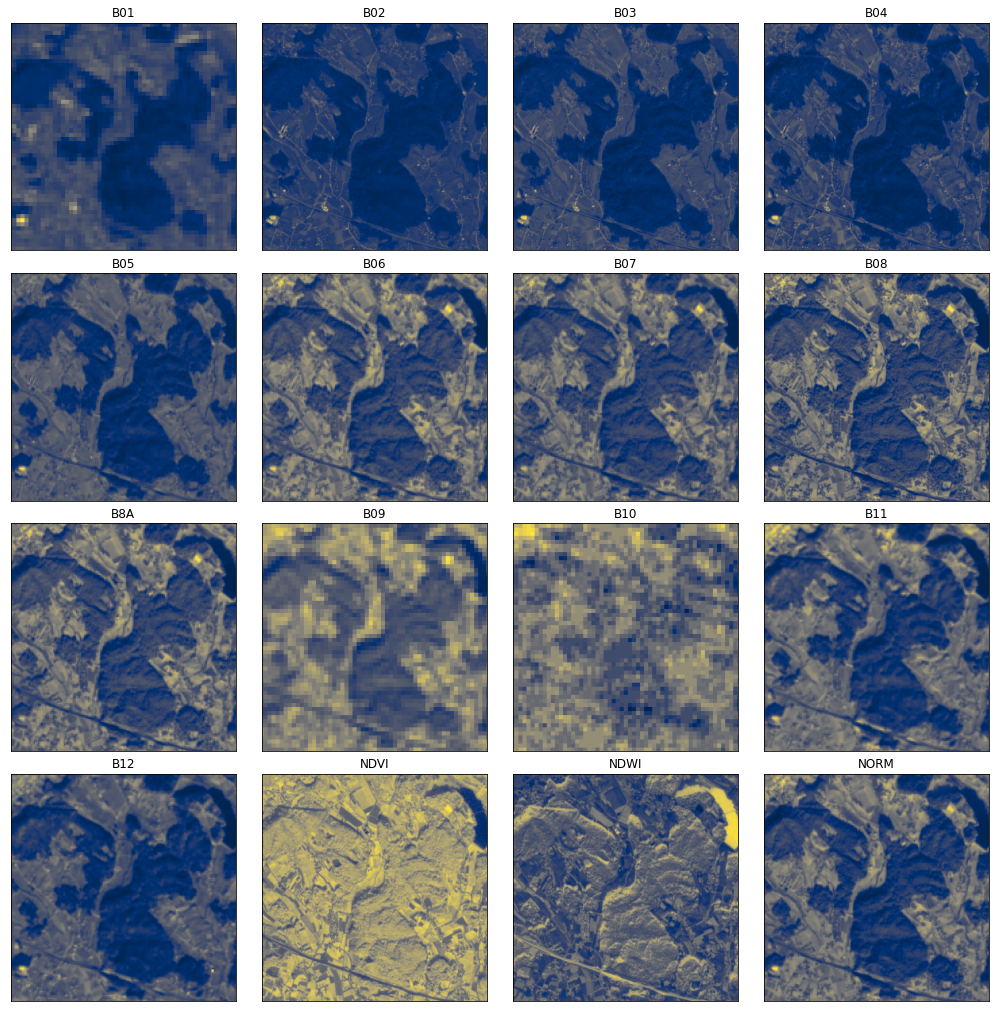

In [31]:
# Load some patch
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_2'), lazy_loading=True)

titles = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12', 'NDVI', 'NDWI', 'NORM']

# Plot
fig, axes = plt.subplots(4,4,figsize=(18,18))

def pretty_plot(ax, data, vmin, vmax, title):
    """
    If there are issues with colour-blindness, change the colour map to something else:
    https://matplotlib.org/tutorials/colors/colormaps.html
    """ 
    
    ax.imshow(data, vmin=vmin, vmax=vmax, cmap=plt.cm.cividis)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Plot bands
for i in range(13):
    data = eopatch.data['BANDS'][0,...,i]
    pretty_plot(axes.flat[i], data, np.min(data), np.max(data), titles[i])

# Plot NDVI
i = 13
data = eopatch.data['NDVI'][0,...,0]
pretty_plot(axes.flat[i], data, np.min(data), np.max(data), titles[i])

# Plot NDWI
i = 14
data = eopatch.data['NDWI'][0,...,0]
pretty_plot(axes.flat[i], data, np.min(data), np.max(data), titles[i])

# Plot NORM
i = 15
data = eopatch.data['NORM'][0,...,0]
pretty_plot(axes.flat[i], data, np.min(data), np.max(data), titles[i])

fig.subplots_adjust(wspace=0., hspace=0.1);

In [ ]:
# Note: If you have added any other custom features, how do they compare?
#       Are they particularly distinct? Do they emphasise a particular class?

The following 9 features may seem like a good choice:
- `B02` (blue band)
- `B03` (green band)
- `B04` (red band)
- `B08` (wide NIR band)
- `B11` (SWIR 1 band)
- `B12` (SWIR 2 band)
- `NDVI`
- `NDWI`
- `NORM`

In [ ]:
# Note: Feature selection may not always be as easy as looking at some plots.
#       How else would you determine which to choose?

#### 3.5.3 Reference map

To make the plot of the reference map more easily readable, it is convenient to define a custom colour map, as such:

In [3]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# Colour map and norm for bin separation
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

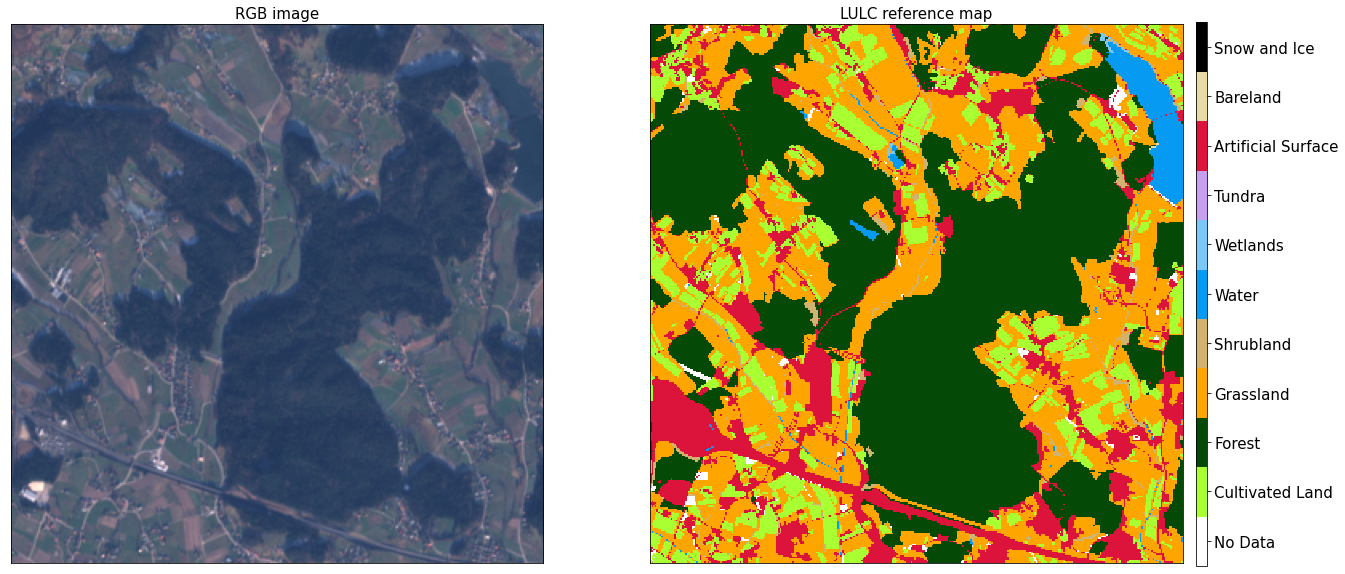

In [5]:
# Load some patch
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_2'), lazy_loading=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,10))

_ = ax1.imshow(np.clip(eopatch.data['BANDS'][0][..., [3,2,1]] * 3.5, 0., 1.))
ref_map = ax2.imshow(eopatch.mask_timeless['LULC'][...,0], interpolation='nearest', cmap=lulc_cmap, norm=lulc_norm)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('RGB image', fontsize=15)
ax2.set_title('LULC reference map', fontsize=15)

cb = fig.colorbar(ref_map, ax=[ax1, ax2], orientation='vertical', pad=0.01, aspect=50)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_yticklabels([entry.class_name for entry in LULC], fontsize=15);

In [ ]:
# Note: 'nearest' interpolation may need to be specified to avoid plotting artifacts.

## 5. Preprocessing pt. 2

This part of the process mostly depends on our model: note that we are dealing with a pixel-based classifier that will take in a set of features for each of the predetermined time-frames and produce a label from multiple classes. 

We will start by creating another workflow:
1. Assemble the features
2. Filter cloudy instances
3. Fill the gaps with temporal interpolation
4. Mark random pixel samples for later extraction

Then we will split the samples for training and validation and construct our data set.

### 5.1 Assembling the features

For later conveniece, we begin by collecting our features into a single array:

In [34]:
class AssembleData(EOTask):
    """
    Collects the specified data features into an assembled array.
    """
    
    def __init__(self, feature_name, source_names_indices):
        self.feature_name = feature_name
        self.source_names_indices = source_names_indices

    def execute(self, eopatch):
        features = [eopatch.data[name][...,idx:idx+1] for name,idx in self.source_names_indices]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(features, axis=-1))

        return eopatch

# TASK FOR CONCATENATION
assemble = AssembleData(
    'FEATURES',
    [('BANDS',1), ('BANDS',2), ('BANDS',3), ('BANDS',7), ('BANDS',11), ('BANDS',12), ('NDVI',0), ('NDWI',0), ('NORM',0)]
)

### 5.2 Filtering

Next, we remove whole ineligible frames, i.e. those that are predominantly cloudy or empty:

In [35]:
class ValidDataFractionPredicate:
    """
    Determines whether a frame is valid,
    i.e. if the fraction of valid data is above the specified threshold.
    """
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

# Keep only frames with above 80% of valid pixels
filter_invalid = SimpleFilterTask(
    (FeatureType.MASK, 'IS_VALID'),
    ValidDataFractionPredicate(0.8)
)

### 5.3 Temporal interpolation

Interpolation will be used not only to replace cloudy pixel instances, but also to create even (and shorter) time-series of data.

Because the data will be resampled to different dates, it would be unconventional to store it in the same patches (timestamps are quite specific). The process should therefore create new patches that will, in the end, be saved to a different location instead.

In [36]:
class CustomInterpolationTask(EOTask):
    """
    Performs linear interpolation on time-series of data.
    """
    
    def __init__(self, feature, mask, copied, n_points=None):
        self.feature = feature    # Data to interpolate
        self.mask = mask          # Determines which values to consider or ignore
        self.copied = copied      # Features to copy to the new patch
        self.n_points = n_points  # Number of interpolating points
        
    def execute(self, eopatch):
        data = eopatch.data[self.feature]
        mask = eopatch.mask[self.mask].astype(bool)
        
        if self.n_points is None:
            self.n_points = len(eopatch.timestamp)
        
        # Convert datetime objects into ordered numbers
        first_date = eopatch.timestamp[0]
        time = np.array([(date - first_date).days for date in eopatch.timestamp])
        
        # Interpolated time points
        new_time = np.linspace(time[0], time[-1], self.n_points)
        
        # New timestamps
        new_timestamp = [first_date + datetime.timedelta(days=days_elapsed) for days_elapsed in new_time]
        
        # Initialise new data array
        new_data = np.empty((self.n_points, *data.shape[1:]), dtype=data.dtype)
        
        for i in range(data.shape[1]):         # Traverse the rows
            for j in range(data.shape[2]):     # Traverse the columns
                for k in range(data.shape[3]): # Travers the channels
                    
                    # Valid time points and corresponding values
                    cond = mask[:,i,j,0]
                    ref_time = time[cond]
                    ref_data = data[cond,i,j,k]

                    new_data[:,i,j,k] = np.interp(new_time, ref_time, ref_data)
        
        # Create new EOPatch
        new_eopatch = EOPatch()
        
        # New features
        new_eopatch.data[self.feature] = new_data
        new_eopatch.timestamp = new_timestamp
        
        # Copied features
        new_eopatch.bbox = eopatch.bbox
        new_eopatch.meta_info = eopatch.meta_info
        
        for feature in self.copied:
            new_eopatch[feature] = eopatch[feature]
        
        return new_eopatch

interpolate = CustomInterpolationTask('FEATURES', 'IS_VALID', [(FeatureType.MASK_TIMELESS, 'LULC')], n_points=23)

In [ ]:
# Note: Yes, Python loops are not recommended in practice, but they should work fast enough for this example.
#       You can use an alternative, if you know of it, or try some form of JIT (just-in-time) compilation.

In [ ]:
# Note: Also, yes, there is already a task for this in eo-learn, but it may return some NaNs.

### 5.4 Sampling

Before sampling, we must consider that some edge pixels (between classes in the reference map) may be incorrectly labelled (they came from simple polygons, after all). Eroding the reference map should leave us with labels of higher confidence:

In [37]:
# Erode a pixel-wide boundary from each class in the reference map
erode = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, 'LULC', 'LULC_ERODED'), disk_radius=1)

Some classes may not be well represented in our small example, so it might make sense to exclude them.

Let's count their occurences for each patch:

In [38]:
lulc_maps = []

for patch_name in os.listdir(PATCH_FOLDER):
    eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, patch_name), lazy_loading=True)
    lulc_maps.append(eopatch.mask_timeless['LULC'][...,0])
    del eopatch

lulc_maps = np.array(lulc_maps)

# Labels
print('          ', np.unique(lulc_maps))

# Counts
for patch_name, lulc_map in zip(os.listdir(PATCH_FOLDER), lulc_maps):
    print(patch_name + ':', np.bincount(lulc_map.flatten()))

           [0 1 2 3 4 5 6 8 9]
eopatch_0: [  783 41028 28759 23789  1998   429     0     0 15435]
eopatch_1: [  751 39183 25888 26198  6101   567     0     0 13533]
eopatch_2: [  741 13700 43995 35469  1500  2213    67     0 14529     7]
eopatch_3: [  787 47103 15488 19749  2430  3488    79     0 23097]
eopatch_4: [  807 61770 14360 14952  4066  1996     0     0 14270]
eopatch_5: [  756 17895 21063 29266  3211  2444     0     0 37586]
eopatch_6: [  413  8660 71190 23073  2069   142     0     0  6674]
eopatch_7: [  227  5630 82168 15913  2205    92    45     0  5941]
eopatch_8: [  341  9273 75823 15430  2559  2086     0     0  6709]


We will be ignoring the following labels:
- `0` (no labelled data)
- `6` (wetlands, not enough data)
- `7` (tundra, no data)
- `9` (bareland, not enough data)
- `10` (snow and ice, no data)

For the rest, we will create a two-way mapping so that the classifier may still work with a `0,...,N` range of labels:

In [39]:
class ReferenceMapping:
    def __init__(self, labels, to_reference, to_new):
        self.labels = labels
        self.to_reference = np.vectorize(to_reference)
        self.to_new = np.vectorize(to_new)


labels = [1,2,3,4,5,8]

def to_reference(x):
    new_to_ref = {0:1, 1:2, 2:3, 3:4, 4:5, 5:8}
    
    return new_to_ref[x]

def to_new(x):
    ref_to_new = {1:0, 2:1, 3:2, 4:3, 5:4, 8:5}
    
    return ref_to_new[x]

mapping = ReferenceMapping(labels, to_reference, to_new)

Using the above mapping, we will produce a sample map, where sampled pixels will be mapped and the rest distinctly marked, so that we know how to differentiate between them later.

Since some classes can be underrepresented, it is best to conduct the sampling separately for each class.

Class imbalance is a significant problem in its own right - here we will simply set the number of samples per class to be proportional to their frequency in the reference map:

In [40]:
class CustomSamplingTask(EOTask):
    def __init__(self, feature, reference_feature, n_samples, mapping, seed=None, even=False):
        self.feature = feature
        self.reference_feature = reference_feature
        self.n_samples = n_samples
        self.mapping = mapping
        self.seed = seed
        self.even = even
    
    def execute(self, eopatch):
        rng = np.random.default_rng(seed=self.seed)
        ref_map = eopatch.mask_timeless[self.reference_feature][...,0]
        labels = self.mapping.labels
        
        if self.even:
            # Number of samples is about the same for each class
            n_samples_per_class = np.diff(np.round(np.linspace(0, self.n_samples, len(labels)+1))).astype(np.uint32)
            
        else:
            # Number of samples per class is proportional to label frequency
            n_labels_per_class = np.array([np.sum(np.where(ref_map == label, 1, 0)) for label in labels])
            
            n_total = np.where(np.logical_or.reduce([ref_map == label for label in labels]))[0].size
            
            label_ratios = n_labels_per_class / n_total
            
            n_samples_per_class = (np.ceil(self.n_samples * label_ratios)).astype(np.uint32)
            
        # Random sampling
        cols = []
        rows = []
        
        for i, label in enumerate(labels):
            class_rows, class_cols = np.where(ref_map == label)
            
            rand_indices = rng.choice(
                class_rows.size,
                size=n_samples_per_class[i],
                replace=class_rows.size < n_samples_per_class[i]
            )
            
            rows.append(class_rows[rand_indices])
            cols.append(class_cols[rand_indices])
        
        rows = np.concatenate(rows)
        cols = np.concatenate(cols)
        
        # Sampled pixels are mapped, the rest are marked with 255 (max value for uint8)
        sample_map = np.ones(ref_map.shape, dtype=np.uint8) * 255
        sample_map[rows,cols] = self.mapping.to_new(ref_map[rows,cols])
        
        eopatch.mask_timeless[self.feature] = sample_map[...,np.newaxis]
        
        return eopatch

sample = CustomSamplingTask('SAMPLE_MAP', 'LULC_ERODED', int(4e+4), mapping, seed=42)

In [ ]:
# Note: The task allows for even sampling as well.

In [ ]:
# Note: The seed is fixed so that the results can be reproduced (by you, if you're strictly following the notebook).

### 5.5 The workflow

I/O:

In [41]:
load = LoadTask(PATCH_FOLDER)

# Def. new output path
OUT_FOLDER = os.path.join(DATA_FOLDER, 'lcc_out_eopatches')

if not os.path.exists(OUT_FOLDER):
    os.makedirs(OUT_FOLDER)

save = SaveTask(OUT_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

This time, the order of operations is important during the entire sequence:

In [42]:
workflow = LinearWorkflow(
    load,
    assemble,
    filter_invalid,
    interpolate,
    erode,
    sample,
    save
)

In [44]:
%%time
   
execution_args = []

for patch_name in os.listdir(PATCH_FOLDER):
    execution_args.append({
        load: {'eopatch_folder': patch_name},
        save: {'eopatch_folder': patch_name}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)
executor.run(workers=1, multiprocess=False)

executor.make_report()

### 5.6 Split for training and validation

It might be interesting to designate an entire patch for validation, while the rest would be used for training. Otherwise, the split should be automatically, e.g. by random sampling.

In both cases, we must ensure that the training set has enough examples, so that the classificer is able to learn properly, and that the validation set is a good representative for our use case, so that we can be confident that it has, indeed, learnt properly.

Let's take a look at the numbers and distribution of samples per class across our patches:

In [45]:
# Labels
print('          ', np.unique(lulc_maps))

# Counts
for patch_name, lulc_map in zip(os.listdir(PATCH_FOLDER), lulc_maps):
    print(patch_name + ':', np.bincount(lulc_map.flatten()))

           [0 1 2 3 4 5 6 8 9]
eopatch_0: [  783 41028 28759 23789  1998   429     0     0 15435]
eopatch_1: [  751 39183 25888 26198  6101   567     0     0 13533]
eopatch_2: [  741 13700 43995 35469  1500  2213    67     0 14529     7]
eopatch_3: [  787 47103 15488 19749  2430  3488    79     0 23097]
eopatch_4: [  807 61770 14360 14952  4066  1996     0     0 14270]
eopatch_5: [  756 17895 21063 29266  3211  2444     0     0 37586]
eopatch_6: [  413  8660 71190 23073  2069   142     0     0  6674]
eopatch_7: [  227  5630 82168 15913  2205    92    45     0  5941]
eopatch_8: [  341  9273 75823 15430  2559  2086     0     0  6709]


In [46]:
lulc_counts = np.array([max(np.sum(lulc_maps == label), 1) for label in labels])

# Labels
print('          ', labels)

# Ratios
for patch_name, lulc_map in zip(os.listdir(PATCH_FOLDER), lulc_maps):
    print(patch_name + ':', np.round(np.bincount(lulc_map.flatten())[labels] / lulc_counts * 100., 1))

           [1, 2, 3, 4, 5, 8]
eopatch_0: [16.8  7.6 11.7  7.6  3.2 11.2]
eopatch_1: [16.   6.8 12.9 23.3  4.2  9.8]
eopatch_2: [ 5.6 11.6 17.4  5.7 16.4 10.5]
eopatch_3: [19.3  4.1  9.7  9.3 25.9 16.8]
eopatch_4: [25.3  3.8  7.3 15.6 14.8 10.4]
eopatch_5: [ 7.3  5.6 14.4 12.3 18.2 27.3]
eopatch_6: [ 3.5 18.8 11.3  7.9  1.1  4.8]
eopatch_7: [ 2.3 21.7  7.8  8.4  0.7  4.3]
eopatch_8: [ 3.8 20.   7.6  9.8 15.5  4.9]


A few thoughts:
- Patches `0`, `1`, `6`, and `7` contain very few water (5) samples.
- Patches `6`,`7`, and `8` contain few cultivated land (1) samples.
- Patch `1` takes up a lot of shrubland (4) samples.
- Patch `3` takes up a lot of water (5) samples.
- Patch `4` takes up a lot of cultivated land samples (1).
- Patch `5` takes up a lot of artificial surface samples (8).

Although patch `5` takes up a lot of artificial surface samples, there is still a lot of them left in absolute terms, so the training set shouldn't be much affected, if we choose it for validation.

We split our patches accordingly:

In [47]:
val_id = 5
train_ids = list(range(5)) + list(range(6,9))

In [ ]:
# Note: You can choose any other patch you like.

### 5.7 Data set construction

The sampled features and labels are loaded and reshaped into shape $n \times m$, where $n$ represents the number of pixel samples, and $m = f \times t$ the number of all features, with $f$ being the size of bands and band combinations and $t$ the length of the resampled time-series.

In [221]:
# Training set
data_train = []
labels_train = []

for i in train_ids:
    eopatch = EOPatch.load(os.path.join(OUT_FOLDER, 'eopatch_%d' % i), lazy_loading=True)
    
    features = eopatch.data['FEATURES']
    labels = eopatch.mask_timeless['SAMPLE_MAP'][...,0]
    
    # Find sampled pixels
    rows,cols = np.where(labels != 255)
    labels = labels[rows,cols]
    
    # Rows of samples, columns of features
    features = np.moveaxis(features, 0, 2)
    features = features[rows,cols]
    features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])
    
    data_train.append(features)
    labels_train.append(labels)
    
    del eopatch

data_train = np.vstack(data_train)
labels_train = np.concatenate(labels_train)


# Validation set
eopatch = EOPatch.load(os.path.join(OUT_FOLDER, 'eopatch_%d' % val_id), lazy_loading=True)

features = eopatch.data['FEATURES']
labels = eopatch.mask_timeless['SAMPLE_MAP'][...,0]

# Find sampled pixels
rows,cols = np.where(labels != 255)
labels = labels[rows,cols]

# Rows of samples, columns of features
features = np.moveaxis(features, 0, 2)
features = features[rows,cols]
features = features.reshape(features.shape[0], features.shape[1]*features.shape[2])

data_valid = features
labels_valid = labels

data_train.shape, labels_train.shape, data_valid.shape, labels_valid.shape

((320022, 207), (320022,), (40004, 207), (40004,))

In [ ]:
# Note: Here, we're considering band values at different time frames as distinct features.
#       Instead, one could compute temporal statistics (mean, standard deviation, minimum, etc.)
#       and end up with fewer features - however, some details might be lost.

At this point, the general recommendation would be to standardise the data. Note that if we were to use standardisation, i.e. subtract the mean and divide by the standard deviation (per each feature), we would need to take this into account during inference time as well.

Since our decision trees should work regardless, we will only shuffle the training data.

In [222]:
rng = np.random.default_rng(seed=42)

indices = np.arange(labels_train.size)
rng.shuffle(indices)

data_train = data_train[indices]
labels_train = labels_train[indices]

One last thing... We must ensure that no `NaN` values have found their way into our data:

In [223]:
np.sum(np.isnan(data_train)), np.sum(np.isnan(data_valid))

(0, 0)

Now we can finally save our completed data sets:

In [224]:
np.savez_compressed(
    os.path.join(DATA_FOLDER, 'lcc_data_set.npz'),
    Xt=data_train,
    yt=labels_train,
    Xv=data_valid,
    yv=labels_valid
)